In [1]:
using QuantEcon
include("uncertainty_traps.jl")
using Gadfly, DataFrames, LaTeXStrings


### Exercise 1

This exercise asked you to validate the laws of motion for $\gamma$ and $\mu$ given in the lecture, based on the stated result about Bayesian updating in a scalar Gaussian setting.  The stated result tells us that after observing average output $X$ of the $M$ firms, our posterior beliefs will be

$$
    N(\mu_0, 1/\gamma_0)
$$

where

$$
    \mu_0 = \frac{\mu \gamma + M X \gamma_x}{\gamma + M \gamma_x}
    \quad \text{and} \quad
    \gamma_0 = \gamma + M \gamma_x
$$

If we take a random variable $\theta$ with this distribution and then evaluate the distribution of $\rho \theta + \sigma_\theta w$ where $w$ is independent and standard normal, we get the expressions for $\mu'$ and $\gamma'$ given in the lecture.

### Exercise 2

First let's replicate the plot that illustrates the law of motion for precision, which is

$$
    \gamma_{t+1} = 
        \left(
        \frac{\rho^2}{\gamma_t + M \gamma_x} + \sigma_\theta^2
        \right)^{-1}
$$

Here $M$ is the number of active firms.  The next figure plots $\gamma_{t+1}$ against 
$\gamma_t$ on a 45 degree diagram for different values of $M$

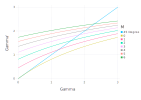

In [2]:
econ = UncertaintyTrapEcon()
rho, sig_theta, gx = econ.rho, econ.sig_theta, econ.gx # simplify names

# grid for gamma and gamma_{t+1}
γ = linspace(1e-10, 3, 200)
M_range = 0:6
γp = 1 ./ (rho^2 ./ (γ .+ gx.*M_range') + sig_theta^2)

plot(x=repeat(collect(γ), outer=[length(M_range)+1]), 
     y=vec([γ γp]), 
     color=repeat(["45 Degree"; map(string, M_range)], inner=[length(γ)]), 
     Geom.line, Guide.colorkey("M"), Guide.xlabel("Gamma"), Guide.ylabel("Gamma'"))

The points where the curves hit the 45 degree lines are the long run steady states corresponding to each $M$, if that value of $M$ was to remain fixed.   As the number of firms falls, so does the long run steady state of precision.

Next let's generate time series for beliefs and the aggregates -- that is, the number
of active firms and average output.

In [3]:
function QuantEcon.simulate(uc::UncertaintyTrapEcon, capT::Int=2000)
    # allocate memory
    μ_vec = Array(Float64, capT)
    θ_vec = Array(Float64, capT)
    γ_vec = Array(Float64, capT)
    X_vec = Array(Float64, capT)
    M_vec = Array(Int, capT)

    # set initial using fields from object
    μ_vec[1] = uc.mu
    γ_vec[1] = uc.gamma
    θ_vec[1] = 0

    # draw standard normal shocks
    w_shocks = randn(capT)

    for t=1:capT-1
        X, M = gen_aggregates(uc)
        X_vec[t] = X
        M_vec[t] = M

        update_beliefs!(uc, X, M)
        update_theta!(uc, w_shocks[t])

        μ_vec[t+1] = uc.mu
        γ_vec[t+1] = uc.gamma
        θ_vec[t+1] = uc.theta
    end

    # Record final values of aggregates
    X, M = gen_aggregates(uc)
    X_vec[end] = X
    M_vec[end] = M

    return μ_vec, γ_vec, θ_vec, X_vec, M_vec
end

simulate (generic function with 9 methods)

First let's see how well $\mu$ tracks $\theta$ in these simulations

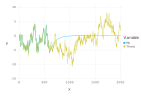

In [4]:
srand(42)  # set random seed for reproducible results
μ_vec, γ_vec, θ_vec, X_vec, M_vec = simulate(econ)

p=plot(x=repeat(collect(1:length(μ_vec)), outer=[2]),
     y=[μ_vec; θ_vec],
     color=repeat(["Mu", "Theta"], inner=[length(μ_vec)]),
     Geom.line, Guide.colorkey("Variable"))

Now let's plot the whole thing together

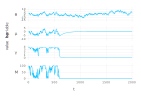

In [5]:
mdf = DataFrame(t=1:length(θ_vec), θ=θ_vec, μ=μ_vec, γ=γ_vec, M=M_vec)
plot(stack(mdf, collect(2:5)), x="t", 
     ygroup="variable",
     y="value",
     Geom.subplot_grid(Geom.line, free_y_axis=true))